# Conditional GAN for timeseries generation

The core idea is to use **conditional shifts** to generate counterfactual sets macroeconomic indicator variables based on changes in one key indicator variable. For example, to answer the question whether or not a certain central bank policy would have different consequences given (read: conditional on) the price of a certain commodity is triple that found in the data, one needs to be able to model the effect of changes in variable B (the price of commodity X) on all other variables in the dataset. To formalize,

$$ P(y,x) = P(X|y,x), y \in X, x \in X$$

for the condition variable $y$ and the conditioned variables $x \subseteq X$. From a Bayesian point of view, the CGAN therefore needs to
1. Approximate the posterior of $y$ given $x$ ($p(x|y)$) *as a prior*.
2. Infer the posterior distribution $p(\theta|x) \propto p(x|\theta)p(x|y)$ of the model generative parameters $\theta$.
3. Use the inferred posterior of $x$ to generate $Y = c,P(x|c,s,\theta)$, where $c$ is the conditioned form of $y$ shifted to simulate some explicitly programmed counterfactual scenario $s$, and $P(x|c,s)$ are the values of $x$ mapped onto this counterfactual scenario $s$. 

Given that a scenario $s$ can also be modeled as a regime, it might be good to look into RL research on the topic of policy switches in model-based RL.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

#### Load and prepare the data

In [4]:
country = 'France'

In [5]:
features_df = pd.read_csv('features/m_one/%s_features.csv' % country, sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [6]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [7]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


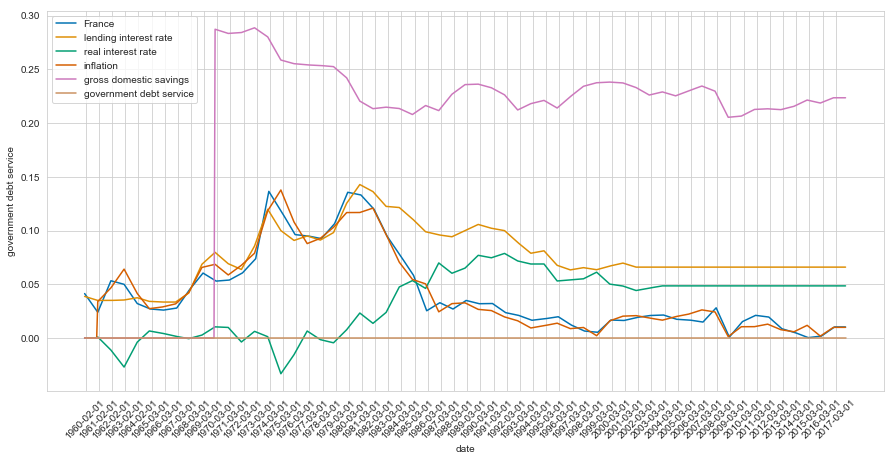

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [9]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'urban population', 'Brazil', 'China', 'Colombia', 'France', 'Ghana',
       'India', 'Indonesia', 'Japan', 'Netherlands', 'Seneg

In [10]:
base_feature_df = combined_df[['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'urban population', country]]

In [30]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date');

In [12]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

In [46]:
gan_df = base_df[['label']]
gan_df.shape

(696, 1)

In [47]:
gan_cols = gan_df.shape[1]

## Simple conditional generative adverserial network

In [190]:
from keras.models import Sequential, Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [293]:
gan_params = {
   'num_epochs': 3000,
   'save_interval': 100,
   'sequence_length': 3,
   'num_variables': gan_cols,
   'batch_size': 16,
   'lr': 0.001 
}

In [294]:
generator_params = {
   'dropout': 0.4,
   'gru_units': 256,
   'lr': 0.001
}

In [295]:
discriminator_params = {
   'bi_lstm_units': 32,
   'dropout_rate': 0.3,
   'lr': 0.001
}

In [296]:
gan_features = []
gan_labels = []

for i in range(int(num_obs / gan_params['sequence_length'])):
    gan_labels_df = gan_df['label']
    gan_labels.append(gan_labels_df[i:(i+gan_params['sequence_length'])].values[-1:])
    gan_features.append(gan_df[i:(i+gan_params['sequence_length'])].values)

In [297]:
real = np.asarray(gan_features)
real = real.reshape((real.shape[0], gan_params['sequence_length'], gan_cols))

In [298]:
real.shape

(232, 3, 1)

### Generator

In [303]:
from keras.layers import TimeDistributed, GRU, GaussianNoise, Dense, Reshape

def build_generator(params):
    gshape = params['sequence_length'], params['num_variables']
    inputs = Input(shape=(gshape))
    
    g = Sequential(name='generator')
    g.add(GRU(params['gru_units'], input_shape=(gshape), return_sequences=True))
    g.add(TimeDistributed(GaussianNoise(params['dropout'])))
    g.add(TimeDistributed(Dense(params['num_variables'])))
    g.add(Reshape(target_shape=(gshape)))
    g.summary()
    
    return Model(inputs, g(inputs))

In [304]:
generator = build_generator({**gan_params, **generator_params})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, 3, 256)            198144    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 3, 256)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 1)              257       
_________________________________________________________________
reshape_17 (Reshape)         (None, 3, 1)              0         
Total params: 198,401
Trainable params: 198,401
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [305]:
from keras.layers import Bidirectional, LSTM, Dense, concatenate, Flatten

def build_discriminator(params):
    dshape = params['sequence_length'], params['num_variables']
    batch_shape = params['batch_size'], params['sequence_length'], params['num_variables']
    
    real = Input(shape=(dshape))
    generated = Input(shape=(dshape))
    inputs = concatenate([generated, real], axis=1)
    
    d = Sequential(name='discriminator')
    d.add(Bidirectional(LSTM(params['bi_lstm_units']), batch_input_shape=(batch_shape)))
    d.add(Dropout(params['dropout_rate']))
    d.add(Dense(1, activation='sigmoid'))
    d.summary()
    return Model([generated, real], d(inputs))

In [306]:
discriminator = build_discriminator({**gan_params, **discriminator_params})
discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (16, 64)                  8704      
_________________________________________________________________
dropout_29 (Dropout)         (16, 64)                  0         
_________________________________________________________________
dense_36 (Dense)             (16, 1)                   65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


### CGAN

In [307]:
def build_cgan(generator, discriminator, params):
    ganshape = params['sequence_length'], params['num_variables']
    discriminator.trainable = False
    
    noise = Input(shape=(ganshape))
    generated = generator(noise)
    data = Input(shape=(ganshape))
    prediction = discriminator([data, generated])
    
    cgan = Model([noise, data], prediction, name='cgan')
    cgan.summary()
    return cgan

In [308]:
cgan = build_cgan(generator, discriminator, gan_params)
cgan.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_92 (InputLayer)           (None, 3, 1)         0                                            
__________________________________________________________________________________________________
model_33 (Model)                (None, 3, 1)         198401      input_91[0][0]                   
__________________________________________________________________________________________________
model_34 (Model)                (None, 1)            8769        input_92[0][0]                   
                                                                 model_33[1][0]                   
Total para

In [309]:
def train_cgan(real, batch_size, params):
    g_metrics = []
    d_metrics = []
    
    reals = np.ones(batch_size)
    synths = np.zeros(batch_size)
    
    for i in range(params['num_epochs']):
        # create input of real and synthetic data
        random_index = np.random.randint(0, len(real) - batch_size)
        half_real = real[random_index:int(random_index + batch_size)]
        half_synth = np.random.normal(-1.0, 1.0, size=[batch_size, params['sequence_length'], real.shape[2]])
        
        # apply generator
        generated = generator.predict(half_synth)
        
        # train discriminator
        disc = discriminator.train_on_batch([generated, half_real], reals)
                                                            
        # train gan
        gen_ = cgan.train_on_batch([half_synth, generated], [reals])
        if i % 100 == 0:
            print('Epoch %s losses: discriminator %s, generator: %s' % (i, str(disc[0]), str(gen_[0])))
        
        d_metrics.append(disc)
        g_metrics.append(gen_)
    return d_metrics, g_metrics

In [310]:
d_metrics, g_metrics = train_cgan(real, gan_params['batch_size'], gan_params)

Epoch 0 losses: discriminator 0.2490153, generator: 0.24607381
Epoch 100 losses: discriminator 0.00012073074, generator: 0.0007783602
Epoch 200 losses: discriminator 5.24293e-05, generator: 3.5036726e-05
Epoch 300 losses: discriminator 2.2983437e-05, generator: 4.3157044e-05
Epoch 400 losses: discriminator 1.0887452e-05, generator: 3.271264e-05
Epoch 500 losses: discriminator 5.6039808e-06, generator: 5.8639154e-05
Epoch 600 losses: discriminator 3.0626795e-06, generator: 9.629711e-05
Epoch 700 losses: discriminator 1.4653377e-06, generator: 8.679143e-05
Epoch 800 losses: discriminator 5.375361e-06, generator: 8.572135e-07
Epoch 900 losses: discriminator 3.4408636e-06, generator: 0.00011967552
Epoch 1000 losses: discriminator 9.666694e-07, generator: 1.3048624e-05
Epoch 1100 losses: discriminator 2.0848524e-06, generator: 0.00030358907
Epoch 1200 losses: discriminator 1.003442e-06, generator: 4.606428e-07
Epoch 1300 losses: discriminator 1.7358473e-06, generator: 3.5581816e-05
Epoch 14

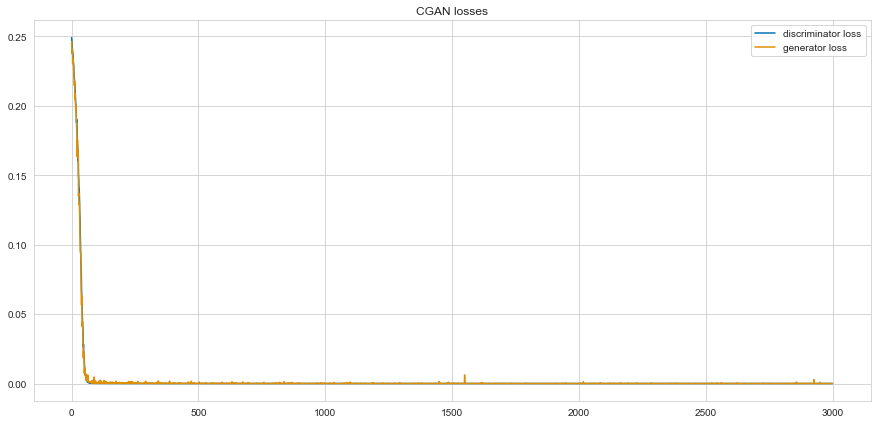

In [311]:
plt.figure(figsize=(15,7))
plt.plot([metrics[0] for metrics in d_metrics], label='discriminator loss')
plt.plot([metrics[0] for metrics in g_metrics], label='generator loss')
plt.legend()
plt.title('CGAN losses')
plt.show()

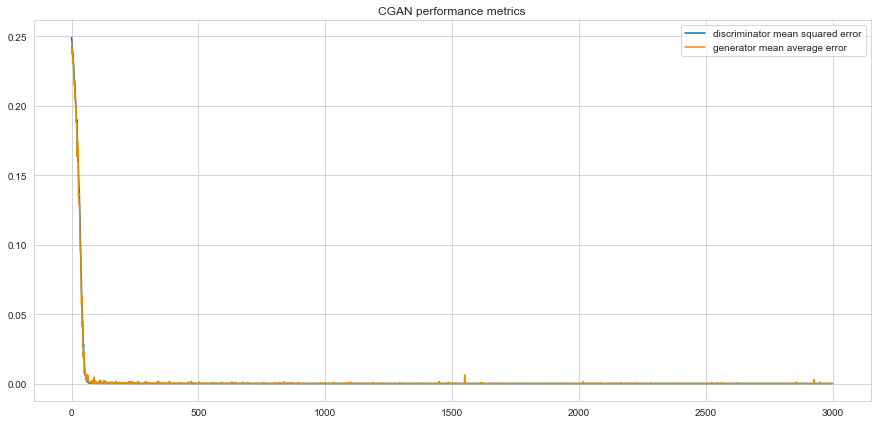

In [312]:
plt.figure(figsize=(15,7))
plt.plot([metrics[1] for metrics in d_metrics], label='discriminator mean squared error')
plt.plot([metrics[1] for metrics in g_metrics], label='generator mean average error')
plt.legend()
plt.title('CGAN performance metrics')
plt.show()

In [313]:
generated_y = generator.predict(np.random.rand(num_obs, gan_params['sequence_length'], gan_cols))[:,-1,-1]
gan_y = gan_df['label'].values

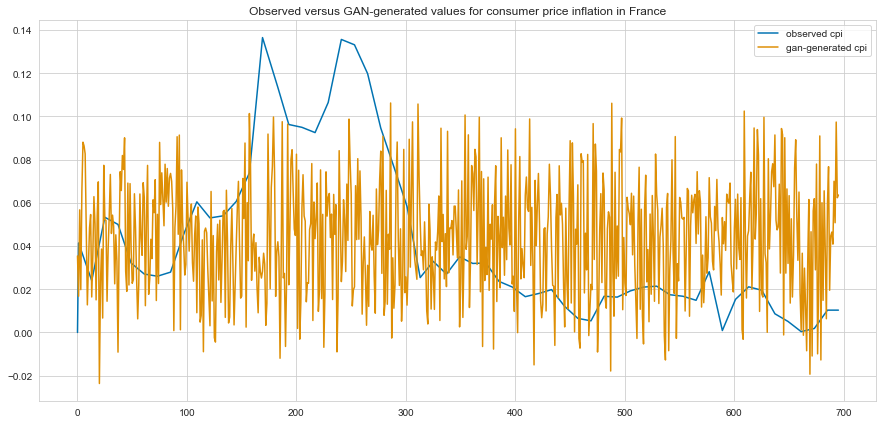

In [314]:
plt.figure(figsize=(15,7))
plt.plot(gan_y, label='observed cpi')
plt.plot(generated_y, label='gan-generated cpi')
plt.legend()
plt.title('Observed versus GAN-generated values for consumer price inflation in %s' % country)
plt.show()

In [315]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(gan_y, generated_y)),
                                                           np.mean(gan_y), np.mean(generated_y)))

rmse: 0.04604181765813708
mean observed: 0.04203555603346822
mean generated: 0.043807212
